# <center>Assignment 2 LSTM - Fixed Window Size Loop with First Order Difference & Seasonal Difference (Final Model)
   

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Basic Time Series Setting
import statsmodels.api as smapi
import statsmodels.tsa.api as smt

In [3]:
# RNN Package Setting
import time
import math
import statsmodels.api as smapi
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers

np.random.seed(1)

Using Theano backend.


In [79]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [80]:
def mean_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(y_true - y_pred)

## Data Preparation & Exploratory Data Analysis

In [4]:
data=pd.read_csv('internet_retail_sales.csv',parse_dates=[0], index_col=0)
sales=data.values

### First Order Difference & Seasonal Difference

#### First Order Difference

In [5]:
sales_diff_trial=pd.Series.diff(data)
sales_diff_trial=sales_diff_trial.dropna()

#### First Order Difference ACF Plot

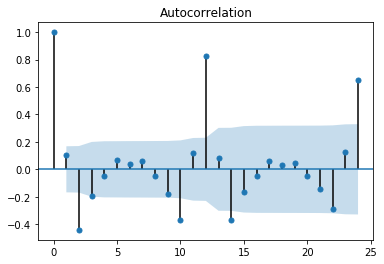

In [6]:
fig=smt.graphics.plot_acf(sales_diff_trial, lags=24)
plt.show()
fig.savefig('ACF.png',dpi=1000)

#### First Order Difference PACF Plot

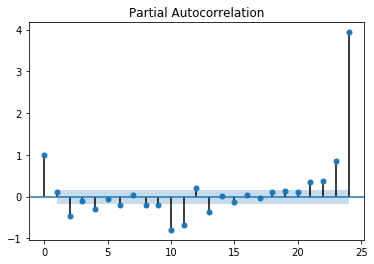

In [7]:
fig=smt.graphics.plot_pacf(sales_diff_trial, lags=24)
plt.show()
fig.savefig('PACF.png',dpi=1000)

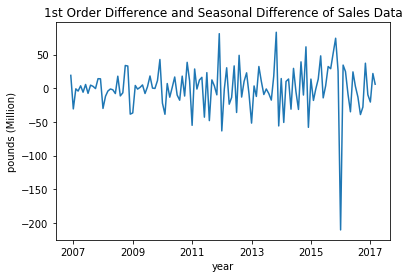

In [188]:
# First Order Difference

# plt.plot(date,sales_trend[:-1])
# sales_diff=pd.Series.diff(data)
# sales_diff=sales_diff.dropna().values

# Seasonally First Order Difference
season_diff=pd.Series.diff(sales_diff,periods=12)

season_diff=season_diff.dropna().values

fig=plt.figure()
date=pd.date_range(start='11/10/2005',end='03/01/2017',freq='MS')
plt.plot(date[-len(season_diff):],season_diff)
plt.xlabel('year')
plt.ylabel('pounds (Million)')
plt.title('1st Order Difference and Seasonal Difference of Sales Data')
plt.show()
fig.savefig('2ndord.png',dpi=1000)

#### First Order & Seasonal Difference ACF Plot

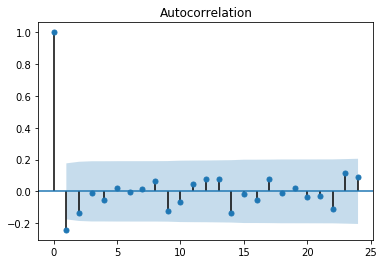

In [10]:
fig=smt.graphics.plot_acf(season_diff, lags=24)
plt.show()
fig.savefig('SACF.png',dpi=1000)

#### First Order & Seasonal Difference PACF Plot

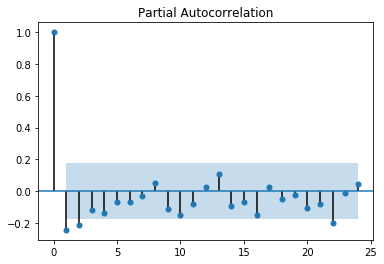

In [11]:
fig=smt.graphics.plot_pacf(season_diff, lags=24)
plt.show()
fig.savefig('SPACF.png',dpi=1000)

### Standardisation

In [13]:
# Standardisation
scaler = StandardScaler()
diff_scaled=scaler.fit_transform(season_diff)

# Std & Mean Calculation
diff_std=np.std(season_diff)
diff_mean=np.mean(season_diff)

print(diff_std)
print(diff_mean)

33.54436470729509
0.30564516129032193


## LSTM - Model Training

**Data**: First Order Difference + Seasonal Difference
<br>
**Model:**
-  LSTM Fixed Window size=2
-  Neurons=1
-  Combine 30 Repeat and use the average forecast result as our final prediction
<br>
We tuning our hyperparameters here, including **neurons, window size and epochs**


In [81]:
# Memory Variables preparation
test_loss_sum=[]
training_final_loss_sum=[]
hyper_para=[]
hyper_para_sum=[]

In [82]:
# Model Fitting
epochs=100
repeats=10

neurons_min=6
neurons_max=7

window_min=3
window_max=4

step=1

train_loss=[]
train_loss_res=[]

cv_loss=[]
cv_loss_res=[]

test_loss=[]
training_final_loss=[]

test_predict_pse_sum=[]
train_predict_pse_sum=[]

len_window=[]

for w in range(window_min,window_max):
       
    time_window=w
    
    Xall, yall=[],[]
    for i in range(time_window, len(diff_scaled)):
        Xall.append(diff_scaled[i-time_window:i,0])
        yall.append(diff_scaled[i,0])     
    Xall=np.array(Xall)
    yall=np.array(yall)
    
    len_window=len(Xall)
    
    # Real Train Test Split
    test_size=12
    Xtrain, Xtest=Xall[0:-test_size], Xall[-test_size:]
    ytrain, ytest=yall[0:-test_size], yall[-test_size:]
    
    # Unscaled Data Preparation for Evaluation
    y_total=season_diff[-len(Xall):]
    y_train_raw=y_total[0:-test_size]
    y_test_raw=y_total[-test_size:]   

    # Validation Train Test Split
    Xtrain_pse, Xtest_pse=Xtrain[0:-test_size], Xtrain[-test_size:]
    ytrain_pse, ytest_pse=ytrain[0:-test_size], ytrain[-test_size:]

    # Unscaled Data Preparation for Evaluation
    # Trend
    y_train_pse_raw=y_train_raw[0:-test_size]
    y_test_pse_raw=y_train_raw[-test_size:]    

    # Real Train Test Split Reshape 
    Xtrain, Xtest=Xtrain.reshape(Xtrain.shape[0], time_window, 1), Xtest.reshape(Xtest.shape[0], time_window, 1)
    # Validation Train Test Split Reshape
    Xtrain_pse, Xtest_pse=Xtrain_pse.reshape(Xtrain_pse.shape[0], time_window, 1), Xtest_pse.reshape(Xtest_pse.shape[0], time_window, 1)

    
    for n in range(neurons_min,neurons_max,step):
        
        rmse_t_test=[]
        rmse_t_train=[]
        test_predict_pse_sum_t=[]
        train_predict_pse_sum_t=[]
            
        for j in range(repeats):

            model=Sequential()
            model.add(LSTM(n,input_shape = (time_window,1), batch_size=1,stateful=True))
            model.add(Dropout(0.2))
            model.add(Dense(1,activation='linear'))
            #     model.add(Dense(1))

            # compile model for use
            start=time.time()
            model.compile(loss="mse", optimizer="rmsprop")
            print("Compilation Time : ", time.time() - start)

            train_loss_t=[]
            cv_loss_t=[]   
            for i in range(epochs):
                history=model.fit(Xtrain_pse,ytrain_pse, epochs=1, batch_size=1, verbose=2,validation_split=0.1,shuffle=False)
                train_loss_t.append(history.history['loss'])
                cv_loss_t.append(history.history['val_loss'])
                model.reset_states()

            # Loss Calculation  
            # Validation Prediction 
            test_predict_pse = model.predict(Xtest_pse,batch_size=1)
            test_predict_pse=scaler.inverse_transform(test_predict_pse)  
            test_predict_pse_sum_t.append(np.array(test_predict_pse))
            # Training Prediction
            train_predict_pse=model.predict(Xtrain_pse,batch_size=1)
            train_predict_pse=scaler.inverse_transform(train_predict_pse)
            train_predict_pse_sum_t.append(np.array(train_predict_pse))
            
            # Test RMSE
            rmse_t_test.append(math.sqrt(mean_squared_error(y_test_pse_raw,test_predict_pse)))
            
            # Training RMSE
            rmse_t_train.append(math.sqrt(mean_squared_error(y_train_pse_raw,train_predict_pse)))
            
            # cross validation loss
            cv_loss.append(np.array(cv_loss_t))
            cv_loss_res.append(np.array(cv_loss_t)*diff_std)
            # training loss
            train_loss.append(np.array(train_loss_t))            
            train_loss_res.append(np.array(train_loss_t)*diff_std)
        
        # summary statistics      
        # Model Combination Predicting
        test_predict_pse_sum.append(np.mean(np.array(test_predict_pse_sum_t),axis=0)) # validation
        train_predict_pse_sum.append(np.mean(np.array(train_predict_pse_sum_t),axis=0)) # training
        
        # Validation RMSE
        rmse_t_test.append(np.std(rmse_t_test))
        rmse_t_test.append(math.sqrt(mean_squared_error(y_test_pse_raw,np.mean(np.array(test_predict_pse_sum_t),axis=0)))) # calculate mean and std of Trend RMSE
        test_loss.append(rmse_t_test) # append Combination RMSE
        # Training RMSE
        rmse_t_train.append(np.std(rmse_t_train))
        rmse_t_train.append(math.sqrt(mean_squared_error(y_train_pse_raw,np.mean(np.array(train_predict_pse_sum_t),axis=0)))) # calculate mean and std of Trend RMSE
        training_final_loss.append(rmse_t_train) # append Combination RMSE

Compilation Time :  0.01289057731628418
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6671 - val_loss: 1.0774
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6534 - val_loss: 1.0620
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6478 - val_loss: 1.0459
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6460 - val_loss: 1.0295
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6330 - val_loss: 1.0142
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6217 - val_loss: 0.9980
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6112 - val_loss: 0.9807
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6085 - val_loss: 0.9658
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5971 - val_loss: 0.9493
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5949 - val_loss: 0.9330
Train on 87 samples,

Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4615 - val_loss: 0.5918
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4623 - val_loss: 0.5893
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4452 - val_loss: 0.5921
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4678 - val_loss: 0.5902
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4502 - val_loss: 0.5832
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4651 - val_loss: 0.5933
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4816 - val_loss: 0.5841
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4575 - val_loss: 0.5903
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4479 - val_loss: 0.5932
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4597 - val_loss: 0.5987
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s 

Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4478 - val_loss: 0.5995
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4553 - val_loss: 0.6042
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4751 - val_loss: 0.6058
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4669 - val_loss: 0.6066
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4535 - val_loss: 0.6050
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4732 - val_loss: 0.6070
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4658 - val_loss: 0.6060
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4668 - val_loss: 0.6069
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4707 - val_loss: 0.6039
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4416 - val_loss: 0.6066
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s 

Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4554 - val_loss: 0.6106
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4560 - val_loss: 0.6091
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4479 - val_loss: 0.6036
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4671 - val_loss: 0.6061
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4554 - val_loss: 0.5992
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4841 - val_loss: 0.6025
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4639 - val_loss: 0.6038
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5255 - val_loss: 0.6113
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4849 - val_loss: 0.6078
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4871 - val_loss: 0.6024
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s 

Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4777 - val_loss: 0.6316
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4510 - val_loss: 0.6275
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4480 - val_loss: 0.6233
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4728 - val_loss: 0.6267
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4695 - val_loss: 0.6248
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4564 - val_loss: 0.6209
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4720 - val_loss: 0.6204
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4602 - val_loss: 0.6210
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4558 - val_loss: 0.6153
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4564 - val_loss: 0.6134
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s 

Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4794 - val_loss: 0.6487
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4803 - val_loss: 0.6452
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4806 - val_loss: 0.6422
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4660 - val_loss: 0.6381
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4630 - val_loss: 0.6330
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4493 - val_loss: 0.6257
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4616 - val_loss: 0.6224
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4847 - val_loss: 0.6236
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5018 - val_loss: 0.6191
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4628 - val_loss: 0.6153
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s 

Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5037 - val_loss: 0.7213
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4967 - val_loss: 0.7157
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4903 - val_loss: 0.7126
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5111 - val_loss: 0.7035
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5098 - val_loss: 0.6976
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5058 - val_loss: 0.6924
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5120 - val_loss: 0.6872
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5197 - val_loss: 0.6813
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4730 - val_loss: 0.6760
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5084 - val_loss: 0.6748
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s 

Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5407 - val_loss: 0.8074
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5362 - val_loss: 0.7927
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5496 - val_loss: 0.7846
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5247 - val_loss: 0.7747
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5207 - val_loss: 0.7616
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5044 - val_loss: 0.7492
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5106 - val_loss: 0.7374
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5048 - val_loss: 0.7282
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4996 - val_loss: 0.7208
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4795 - val_loss: 0.7063
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4172 - val_loss: 0.5991
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4374 - val_loss: 0.6041
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4292 - val_loss: 0.5964
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4659 - val_loss: 0.5981
Compilation Time :  0.01285862922668457
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6742 - val_loss: 1.0686
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6616 - val_loss: 1.0502
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6534 - val_loss: 1.0321
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6415 - val_loss: 1.0185
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6324 - val_loss: 1.0041
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6256 - val_loss: 0.9917
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.6182

 - 0s - loss: 0.4739 - val_loss: 0.5644
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4212 - val_loss: 0.5644
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4498 - val_loss: 0.5649
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4401 - val_loss: 0.5608
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4553 - val_loss: 0.5654
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4665 - val_loss: 0.5682
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4810 - val_loss: 0.5754
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4606 - val_loss: 0.5634
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4504 - val_loss: 0.5689
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4439 - val_loss: 0.5666
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4730 - val_loss: 0.5665
Train on 87 samples,

 - 0s - loss: 0.4474 - val_loss: 0.5765
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4469 - val_loss: 0.5731
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4453 - val_loss: 0.5754
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4633 - val_loss: 0.5777
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4548 - val_loss: 0.5738
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4960 - val_loss: 0.5787
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4583 - val_loss: 0.5807
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4660 - val_loss: 0.5798
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4646 - val_loss: 0.5735
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4795 - val_loss: 0.5814
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4652 - val_loss: 0.5828
Train on 87 samples,

 - 0s - loss: 0.5227 - val_loss: 0.6004
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4847 - val_loss: 0.5978
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4919 - val_loss: 0.5949
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4832 - val_loss: 0.5934
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4769 - val_loss: 0.5906
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5088 - val_loss: 0.5929
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5081 - val_loss: 0.5947
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4556 - val_loss: 0.5908
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4652 - val_loss: 0.5884
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.4800 - val_loss: 0.5879
Train on 87 samples, validate on 10 samples
Epoch 1/1
 - 0s - loss: 0.5119 - val_loss: 0.5878
Train on 87 samples,

### Summary Statistics

#### Validation Loss

In [83]:
pd.DataFrame(test_loss)

,0,1,2,3,4,5,6,7,8,9,10,11
0,89.616383,87.911344,89.559851,85.700429,86.983275,86.264816,80.165901,94.364162,86.416555,92.948197,3.784884,87.452744


In [84]:
# Meomory
test_loss_sum.append(test_loss)
hyper_para.append(neurons_min)
hyper_para.append(epochs)
hyper_para.append(window_min)
hyper_para_sum.append(np.array(hyper_para))

In [85]:
test_loss_sum

[[[89.61638346053498,
   87.91134385664948,
   89.55985089313864,
   85.70042855882032,
   86.98327502207853,
   86.26481560479439,
   80.16590065826311,
   94.36416218797633,
   86.41655489161616,
   92.94819652522601,
   3.7848838342274465,
   87.45274412208688]]]

In [86]:
pd.DataFrame(test_loss_sum).to_excel('test_loss_sum_T2.xlsx')

In [87]:
pd.DataFrame(hyper_para_sum)

,0,1,2
0,6,100,3


#### Training Loss

In [88]:
pd.DataFrame(training_final_loss)

,0,1,2,3,4,5,6,7,8,9,10,11
0,22.750291,22.392579,22.211724,22.538279,21.949951,22.458673,22.349978,22.514562,22.710763,22.580997,0.225237,22.227929


In [89]:
training_final_loss_sum.append(training_final_loss)
training_final_loss_sum

[[[22.750291240334075,
   22.392579247260073,
   22.21172448645467,
   22.538279452018536,
   21.94995131878138,
   22.458673140300913,
   22.349978089160324,
   22.514562016391615,
   22.710762513044823,
   22.58099674656523,
   0.22523679417066,
   22.227928707860748]]]

In [90]:
pd.DataFrame(training_final_loss_sum).to_excel('train_loss_sum_T2.xlsx')

#### Prediction

In [91]:
test_predict_pse_sum=np.array(test_predict_pse_sum)
# test_predict_pse_sum.shape
test_predict_pse_sum=test_predict_pse_sum.reshape(12,1)

train_predict_pse_sum=np.array(train_predict_pse_sum)
# test_predict_pse_sum.shape
train_predict_pse_sum=train_predict_pse_sum.reshape(len_window-2*test_size,1)

In [92]:
test_predict_pse_sum

array([[   6.2740107],
       [  -2.1519713],
       [ -27.630432 ],
       [ -35.578255 ],
       [ -39.419605 ],
       [ -43.205605 ],
       [ -73.56448  ],
       [ -97.84706  ],
       [-105.25563  ],
       [-105.30348  ],
       [  -8.185251 ],
       [ -17.030323 ]], dtype=float32)

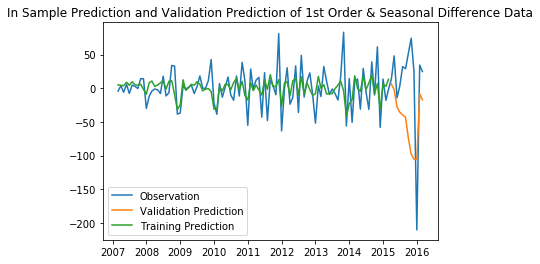

In [93]:
# Prediction Visualization
fig=plt.figure()
date=pd.date_range(start='11/10/2006',end='03/01/2017',freq='MS')
date=date[-len_window:-test_size]
# date_train=date[0:]
# date_train_actual=date[-len_window:-test_size]
plt.plot(date,season_diff[-len_window:-test_size],label='Observation')
plt.plot(date[-test_size:],test_predict_pse_sum,label='Validation Prediction')
plt.plot(date[0:-test_size],train_predict_pse_sum,label='Training Prediction')
plt.legend()
plt.title('In Sample Prediction and Validation Prediction of 1st Order & Seasonal Difference Data')
plt.show()
fig.savefig('S1D1ForecaastV.png',dpi=1000)

#### Forecast Recovery

In [94]:
# Reshift Back to First Order Difference
season_shift=sales_diff.shift(12)[-len_window:].values
season_is_forecast_rec=train_predict_pse_sum+season_shift[0:-2*test_size]
season_v_forecast_rec=test_predict_pse_sum+season_shift[-2*test_size:-test_size]
# Reshift to Orignal Data
fst_shift=data.shift(1)[-len_window:].values
is_forecast_rec=season_is_forecast_rec+fst_shift[0:-2*test_size]
v_forecast_rec=season_v_forecast_rec+fst_shift[-2*test_size:-test_size]

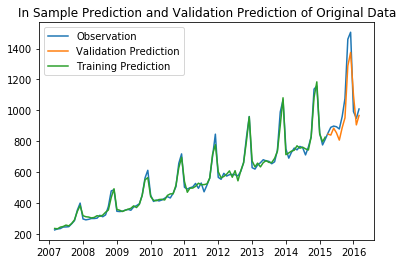

In [95]:
# Original Data Prediction Visualization
fig=plt.figure()
date=pd.date_range(start='11/10/2006',end='03/01/2017',freq='MS')
date=date[-len_window:-test_size]
# date_train=date[0:]
# date_train_actual=date[-len_window:-test_size]
plt.plot(date,sales[-len_window:-test_size],label='Observation')
plt.plot(date[-test_size:],v_forecast_rec,label='Validation Prediction')
plt.plot(date[0:-test_size],is_forecast_rec,label='Training Prediction')
plt.legend()
plt.title('In Sample Prediction and Validation Prediction of Original Data')
plt.show()
fig.savefig('ForecaastV.png',dpi=1000)

#### Training and Cross Validation Loss

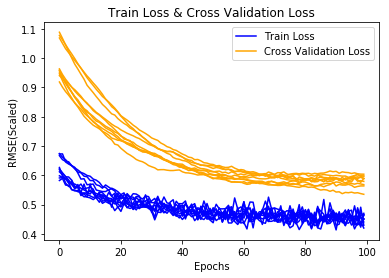

In [96]:
# Cross Validation Visualization
fig=plt.figure()
line1=plt.plot(np.array(train_loss)[0,:],color='blue',label="Train Loss")
plt.plot(np.array(train_loss)[1,:],color='blue')
plt.plot(np.array(train_loss)[2,:],color='blue')
plt.plot(np.array(train_loss)[3,:],color='blue')
plt.plot(np.array(train_loss)[4,:],color='blue')
plt.plot(np.array(train_loss)[5,:],color='blue')
plt.plot(np.array(train_loss)[6,:],color='blue')
plt.plot(np.array(train_loss)[7,:],color='blue')
plt.plot(np.array(train_loss)[8,:],color='blue')
plt.plot(np.array(train_loss)[9,:],color='blue')
# plt.plot(np.array(train_loss)[10,:],color='blue')
# plt.plot(np.array(train_loss)[11,:],color='blue')
# plt.plot(np.array(train_loss)[12,:],color='blue')
# plt.plot(np.array(train_loss)[13,:],color='blue')
# plt.plot(np.array(train_loss)[14,:],color='blue')
# plt.plot(np.array(train_loss)[15,:],color='blue')
# plt.plot(np.array(train_loss)[16,:],color='blue')
# plt.plot(np.array(train_loss)[17,:],color='blue')
# plt.plot(np.array(train_loss)[18,:],color='blue')
# plt.plot(np.array(train_loss)[19,:],color='blue')
# plt.plot(np.array(train_loss)[20,:],color='blue')
# plt.plot(np.array(train_loss)[21,:],color='blue')
# plt.plot(np.array(train_loss)[22,:],color='blue')
# plt.plot(np.array(train_loss)[23,:],color='blue')
# plt.plot(np.array(train_loss)[24,:],color='blue')
# plt.plot(np.array(train_loss)[25,:],color='blue')
# plt.plot(np.array(train_loss)[26,:],color='blue')
# plt.plot(np.array(train_loss)[27,:],color='blue')
# plt.plot(np.array(train_loss)[28,:],color='blue')
# plt.plot(np.array(train_loss)[29,:],color='blue')



line2=plt.plot(np.array(cv_loss)[0,:],color='orange',label= "Cross Validation Loss")
plt.plot(np.array(cv_loss)[1,:],color='orange')
plt.plot(np.array(cv_loss)[2,:],color='orange')
plt.plot(np.array(cv_loss)[3,:],color='orange')
plt.plot(np.array(cv_loss)[4,:],color='orange')
plt.plot(np.array(cv_loss)[5,:],color='orange')
plt.plot(np.array(cv_loss)[6,:],color='orange')
plt.plot(np.array(cv_loss)[7,:],color='orange')
plt.plot(np.array(cv_loss)[8,:],color='orange')
plt.plot(np.array(cv_loss)[9,:],color='orange')
# plt.plot(np.array(cv_loss)[10,:],color='orange')
# plt.plot(np.array(cv_loss)[11,:],color='orange')
# plt.plot(np.array(cv_loss)[12,:],color='orange')
# plt.plot(np.array(cv_loss)[13,:],color='orange')
# plt.plot(np.array(cv_loss)[14,:],color='orange')
# plt.plot(np.array(cv_loss)[15,:],color='orange')
# plt.plot(np.array(cv_loss)[16,:],color='orange')
# plt.plot(np.array(cv_loss)[17,:],color='orange')
# plt.plot(np.array(cv_loss)[18,:],color='orange')
# plt.plot(np.array(cv_loss)[19,:],color='orange')
# plt.plot(np.array(cv_loss)[20,:],color='orange')
# plt.plot(np.array(cv_loss)[21,:],color='orange')
# plt.plot(np.array(cv_loss)[22,:],color='orange')
# plt.plot(np.array(cv_loss)[23,:],color='orange')
# plt.plot(np.array(cv_loss)[24,:],color='orange')
# plt.plot(np.array(cv_loss)[25,:],color='orange')
# plt.plot(np.array(cv_loss)[26,:],color='orange')
# plt.plot(np.array(cv_loss)[27,:],color='orange')
# plt.plot(np.array(cv_loss)[28,:],color='orange')
# plt.plot(np.array(cv_loss)[29,:],color='orange')


plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE(Scaled)')
plt.title('Train Loss & Cross Validation Loss')
plt.show()
fig.savefig('loss_output.png',dpi=1000)

## Final Optimal Model Fitting

We train our optimal selected model here with the following hyperparameters:
-  Neurons=1
-  Window=3
-  Epochs=300
and we will calculate the **1-step ahead forecast and dynamic forecast RMSE MAD MAPE and ME** here for our real test set

In [156]:
# Model Fitting
###################### Variable Preparation ########################
epochs=300
repeats=30

neurons_min=1
neurons_max=2

window_min=3
window_max=4

step=1

train_loss=[]
train_loss_res=[]

cv_loss=[]
cv_loss_res=[]

# RMSE
test_loss_rmse_1stp=[]
test_loss_rmse_dyn=[]
training_final_loss_rmse=[]
# MAD
test_loss_mad_1stp=[]
test_loss_mad_dyn=[]
training_final_loss_mad=[]
#MAPE
test_loss_mape_1stp=[]
test_loss_mape_dyn=[]
training_final_loss_mape=[]
#ME
test_loss_me_1stp=[]
test_loss_me_dyn=[]
training_final_loss_me=[]

test_predict_sum_1stp=[]
test_predict_sum_dyn=[]
train_predict_sum=[]

len_window=[]


for w in range(window_min,window_max): # Time Window Iteration
################################## Model Fitting ###############################################       
    time_window=w
    
    Xall, yall=[],[]
    for i in range(time_window, len(diff_scaled)):
        Xall.append(diff_scaled[i-time_window:i,0])
        yall.append(diff_scaled[i,0])     
    Xall=np.array(Xall)
    yall=np.array(yall)
    
    len_window=len(Xall)
    
    # Real Train Test Split
    test_size=12
    Xtrain, Xtest=Xall[0:-test_size], Xall[-test_size:]
    ytrain, ytest=yall[0:-test_size], yall[-test_size:]
    
    # Unscaled Data Preparation for Evaluation
    y_total=season_diff[-len(Xall):]
    y_train_raw=y_total[0:-test_size]
    y_test_raw=y_total[-test_size:]    

    # Real Train Test Split Reshape 
    Xtrain, Xtest=Xtrain.reshape(Xtrain.shape[0], time_window, 1), Xtest.reshape(Xtest.shape[0], time_window, 1)

    for n in range(neurons_min,neurons_max,step): # Neurons Iteration
        
        rmse_t_test_1stp=[]
        rmse_t_test_dyn=[]
        rmse_t_train=[]
        
        mad_t_test_1stp=[]
        mad_t_test_dyn=[]
        mad_t_train=[]
        
        mape_t_test_1stp=[]
        mape_t_test_dyn=[]
        mape_t_train=[]
        
        me_t_test_1stp=[]
        me_t_test_dyn=[]
        me_t_train=[]
        
        test_predict_sum_t_1stp=[]
        test_predict_sum_t_dyn=[]
        train_predict_sum_t=[]
            
        for j in range(repeats): # Repeat Times

            model=Sequential()
            model.add(LSTM(n,input_shape = (time_window,1), batch_size=1,stateful=True))
            model.add(Dropout(0.2))
            model.add(Dense(1,activation='linear'))

            # compile model for use
            start=time.time()
            model.compile(loss="mse", optimizer="rmsprop")
            print("Compilation Time : ", time.time() - start)

            train_loss_t=[]
            cv_loss_t=[]   
            for i in range(epochs):
                history=model.fit(Xtrain,ytrain, epochs=1, batch_size=1, verbose=2,validation_split=0.1,shuffle=False)
                train_loss_t.append(history.history['loss'])
                cv_loss_t.append(history.history['val_loss'])
                model.reset_states()

            ################################# Predict and Loss Calculation #############################
            
            # 1 Step Ahead Prediction -Out of Sample
            test_predict_1stp = model.predict(Xtest,batch_size=1)
            test_predict_1stp=scaler.inverse_transform(test_predict_1stp)  
            test_predict_sum_t_1stp.append(np.array(test_predict_1stp))
            # Dynamic Prediction - Out of Sample
            dynamic_prediction=season_diff[-len_window:-test_size]
            for i in range(len_window-test_size,len_window):
                last_feature=dynamic_prediction[i-time_window:i].reshape(1,time_window, 1)
#                 last_feature.reshape(1,time_window, 1)
                
                next_pred=model.predict(last_feature)
                dynamic_prediction=np.append(dynamic_prediction,next_pred)
            dynamic_prediction=dynamic_prediction.reshape(-1,1)
            dynamic_prediction=scaler.inverse_transform(dynamic_prediction)
            dynamic_prediction=dynamic_prediction[-test_size:]
            test_predict_sum_t_dyn.append(np.array(dynamic_prediction))
            # Training Prediction - In Sample
            train_predict=model.predict(Xtrain,batch_size=1)
            train_predict=scaler.inverse_transform(train_predict)
            train_predict_sum_t.append(np.array(train_predict))
            
            ############### Test Err Calc
            # 1 Step Ahead Error Calc
            rmse_t_test_1stp.append(math.sqrt(mean_squared_error(y_test_raw,test_predict_1stp))) # RMSE
            mad_t_test_1stp.append(mean_absolute_error(y_test_raw,test_predict_1stp)) # MAD
            mape_t_test_1stp.append(mean_absolute_percentage_error(y_test_raw,test_predict_1stp)) # MAPE
            me_t_test_1stp.append(mean_error(y_test_raw,test_predict_1stp)) # ME
            
            # Dynamic Error Calc
            rmse_t_test_dyn.append(math.sqrt(mean_squared_error(y_test_raw,dynamic_prediction))) # RMSE
            mad_t_test_dyn.append(mean_absolute_error(y_test_raw,dynamic_prediction)) # MAD
            mape_t_test_dyn.append(mean_absolute_percentage_error(y_test_raw,dynamic_prediction)) # MAPE
            me_t_test_dyn.append(mean_error(y_test_raw,dynamic_prediction)) # ME
            
            ############## Training Err Calc
            rmse_t_train.append(math.sqrt(mean_squared_error(y_train_raw,train_predict))) # RMSE
            mad_t_train.append(mean_absolute_error(y_train_raw,train_predict)) # MAD
            mape_t_train.append(mean_absolute_percentage_error(y_train_raw,train_predict)) # MAPE
            me_t_train.append(mean_error(y_train_raw,train_predict)) #ME
            
            ################ Cross validation Loss Generated by Model
            cv_loss.append(np.array(cv_loss_t))
            cv_loss_res.append(np.array(cv_loss_t)*diff_std)
            ############### Training loss Loss Generated by Model
            train_loss.append(np.array(train_loss_t))            
            train_loss_res.append(np.array(train_loss_t)*diff_std)
             
        ######### Model Combination Predicting - Average the Repeat results as our final model
        test_predict_sum_1stp.append(np.mean(np.array(test_predict_sum_t_1stp),axis=0)) # 1 Step Ahead Forecst
        test_predict_sum_dyn.append(np.mean(np.array(test_predict_sum_t_dyn),axis=0)) # Dynamic Forecast
        train_predict_sum.append(np.mean(np.array(train_predict_sum_t),axis=0)) # Training
        
        ####################### Test Error Summary ##############################
        # 1 Step Ahead Forecast
        # RMSE
        rmse_t_test_1stp.append(np.std(rmse_t_test_1stp))# std calculation
        rmse_t_test_1stp.append(math.sqrt(mean_squared_error(y_test_raw,np.mean(np.array(test_predict_sum_t_1stp),axis=0)))) # append Combination RMSE
        test_loss_rmse_1stp.append(rmse_t_test_1stp) 
        # MAD
        mad_t_test_1stp.append(np.std(mad_t_test_1stp)) # std calculation
        mad_t_test_1stp.append(mean_absolute_error(y_test_raw,np.mean(np.array(test_predict_sum_t_1stp),axis=0)))# append Combination MAD 
        test_loss_mad_1stp.append(mad_t_test_1stp)       
        # MAPE
        mape_t_test_1stp.append(np.std(mape_t_test_1stp))
        mape_t_test_1stp.append(mean_absolute_percentage_error(y_test_raw,np.mean(np.array(test_predict_sum_t_1stp),axis=0))) # append Combination MAPE
        test_loss_mape_1stp.append(mape_t_test_1stp) 
        # ME
        me_t_test_1stp.append(np.std(me_t_test_1stp))
        me_t_test_1stp.append(mean_error(y_test_raw,np.mean(np.array(test_predict_sum_t_1stp),axis=0))) # append Combination MAPE
        test_loss_me_1stp.append(me_t_test_1stp) 
        
        # Dynamic Forecast
        # RMSE
        rmse_t_test_dyn.append(np.std(rmse_t_test_dyn))# std calculation
        rmse_t_test_dyn.append(math.sqrt(mean_squared_error(y_test_raw,np.mean(np.array(test_predict_sum_t_dyn),axis=0)))) # append Combination RMSE
        test_loss_rmse_dyn.append(rmse_t_test_dyn) 
        # MAD
        mad_t_test_dyn.append(np.std(mad_t_test_dyn)) # std calculation
        mad_t_test_dyn.append(mean_absolute_error(y_test_raw,np.mean(np.array(test_predict_sum_t_dyn),axis=0)))# append Combination MAD 
        test_loss_mad_dyn.append(mad_t_test_dyn)       
        # MAPE
        mape_t_test_dyn.append(np.std(mape_t_test_dyn))
        mape_t_test_dyn.append(mean_absolute_percentage_error(y_test_raw,np.mean(np.array(test_predict_sum_t_dyn),axis=0))) # append Combination MAPE
        test_loss_mape_dyn.append(mape_t_test_dyn) 
        # ME
        me_t_test_dyn.append(np.std(me_t_test_dyn))
        me_t_test_dyn.append(mean_error(y_test_raw,np.mean(np.array(test_predict_sum_t_dyn),axis=0))) # append Combination MAPE
        test_loss_me_dyn.append(me_t_test_dyn) 
        
        ###################### Training Error Summary #############################
        # RMSE
        rmse_t_train.append(np.std(rmse_t_train)) # std calculation
        rmse_t_train.append(math.sqrt(mean_squared_error(y_train_raw,np.mean(np.array(train_predict_sum_t),axis=0))))# append Combination RMSE
        training_final_loss_rmse.append(rmse_t_train) 
        # MAD
        mad_t_train.append(np.std(mad_t_train)) # std calculation
        mad_t_train.append(mean_absolute_error(y_train_raw,np.mean(np.array(train_predict_sum_t),axis=0)))# append Combination MAD
        training_final_loss_mad.append(mad_t_train) 
        # MAPE
        mape_t_train.append(np.std(mape_t_train)) # std calculation
        mape_t_train.append(mean_absolute_percentage_error(y_train_raw,np.mean(np.array(train_predict_sum_t),axis=0)))# append Combination MAD
        training_final_loss_mape.append(mape_t_train) 
        # ME
        me_t_train.append(np.std(me_t_train)) # std calculation
        me_t_train.append(mean_error(y_train_raw,np.mean(np.array(train_predict_sum_t),axis=0)))# append Combination MAD
        training_final_loss_me.append(me_t_train) 
        

Compilation Time :  0.022696971893310547
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6335 - val_loss: 4.5830
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6213 - val_loss: 4.5772
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6313 - val_loss: 4.5763
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6256 - val_loss: 4.5735
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6206 - val_loss: 4.5675
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6270 - val_loss: 4.5602
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6204 - val_loss: 4.5554
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6202 - val_loss: 4.5461
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6199 - val_loss: 4.5376
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 1s - loss: 0.6141 - val_loss: 4.5322
Train on 98 samples

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5288 - val_loss: 4.8764
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5443 - val_loss: 4.8871
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5231 - val_loss: 4.9217
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4828 - val_loss: 4.9491
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5391 - val_loss: 4.9535
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5255 - val_loss: 4.9312
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5186 - val_loss: 4.9188
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5048 - val_loss: 4.9239
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5652 - val_loss: 4.9246
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5247 - val_loss: 4.8881
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4858 - val_loss: 5.2255
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5378 - val_loss: 5.2135
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5173 - val_loss: 5.2108
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5182 - val_loss: 5.1981
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4795 - val_loss: 5.2038
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5022 - val_loss: 5.2405
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4792 - val_loss: 5.2620
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4593 - val_loss: 5.3266
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5284 - val_loss: 5.2772
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4903 - val_loss: 5.2928
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4950 - val_loss: 5.3015
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5180 - val_loss: 5.3504
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5187 - val_loss: 5.3318
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4941 - val_loss: 5.3422
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5304 - val_loss: 5.2985
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5131 - val_loss: 5.3363
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4809 - val_loss: 5.3735
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4738 - val_loss: 5.4108
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5107 - val_loss: 5.3985
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5640 - val_loss: 5.3589
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4656 - val_loss: 5.4183
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5569 - val_loss: 4.8219
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4880 - val_loss: 4.8406
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5281 - val_loss: 4.8536
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5307 - val_loss: 4.8588
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5237 - val_loss: 4.8627
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5300 - val_loss: 4.8734
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5110 - val_loss: 4.8922
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5545 - val_loss: 4.8971
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5289 - val_loss: 4.9006
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4853 - val_loss: 4.9136
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4975 - val_loss: 5.2305
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4747 - val_loss: 5.2218
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5234 - val_loss: 5.2290
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4512 - val_loss: 5.2333
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5221 - val_loss: 5.2168
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4637 - val_loss: 5.2390
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4795 - val_loss: 5.2270
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5003 - val_loss: 5.2283
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4683 - val_loss: 5.2450
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4606 - val_loss: 5.2546
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5283 - val_loss: 5.2163
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4821 - val_loss: 5.3624
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4779 - val_loss: 5.3587
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4844 - val_loss: 5.3721
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4966 - val_loss: 5.3688
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4921 - val_loss: 5.3518
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5024 - val_loss: 5.3499
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4816 - val_loss: 5.3698
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5087 - val_loss: 5.3806
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5242 - val_loss: 5.3703
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4636 - val_loss: 5.3674
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5783 - val_loss: 4.9917
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5626 - val_loss: 5.0018
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5483 - val_loss: 5.0212
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5332 - val_loss: 5.0464
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5680 - val_loss: 5.0456
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5741 - val_loss: 5.0283
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5634 - val_loss: 5.0365
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5660 - val_loss: 5.0397
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5827 - val_loss: 5.0468
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5278 - val_loss: 5.0630
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4977 - val_loss: 5.2370
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5629 - val_loss: 5.2243
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5005 - val_loss: 5.2231
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5384 - val_loss: 5.2049
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5860 - val_loss: 5.1808
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4704 - val_loss: 5.2111
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5024 - val_loss: 5.2213
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5200 - val_loss: 5.2215
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4890 - val_loss: 5.2382
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4784 - val_loss: 5.2311
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5011 - val_loss: 5.2158
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4900 - val_loss: 5.3653
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4608 - val_loss: 5.3779
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4788 - val_loss: 5.4029
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4936 - val_loss: 5.3998
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4822 - val_loss: 5.3883
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5167 - val_loss: 5.3814
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4605 - val_loss: 5.4151
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4813 - val_loss: 5.3997
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4924 - val_loss: 5.4252
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4900 - val_loss: 5.3996
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5134 - val_loss: 5.6770
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4885 - val_loss: 5.6742
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5192 - val_loss: 5.6625
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5118 - val_loss: 5.6845
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5049 - val_loss: 5.6441
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4724 - val_loss: 5.6429
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5290 - val_loss: 5.6472
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4929 - val_loss: 5.6930
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5044 - val_loss: 5.6421
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4979 - val_loss: 5.6507
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5161 - val_loss: 5.5850
Train on 98 samples,

 - 0s - loss: 0.5414 - val_loss: 4.8843
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5292 - val_loss: 4.8891
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5110 - val_loss: 4.8968
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5556 - val_loss: 4.9109
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5525 - val_loss: 4.9198
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4909 - val_loss: 4.9325
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5034 - val_loss: 4.9377
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5732 - val_loss: 4.9337
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5092 - val_loss: 4.9186
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5537 - val_loss: 4.9292
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5007 - val_loss: 4.9396
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5085 - val_loss: 5.2370
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4800 - val_loss: 5.2246
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4696 - val_loss: 5.2037
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4973 - val_loss: 5.2084
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4766 - val_loss: 5.1983
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4939 - val_loss: 5.1979
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5216 - val_loss: 5.1891
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4711 - val_loss: 5.2025
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4902 - val_loss: 5.2106
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4590 - val_loss: 5.2251
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4772 - val_loss: 5.4266
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5046 - val_loss: 5.4149
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5326 - val_loss: 5.3935
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4897 - val_loss: 5.3805
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5153 - val_loss: 5.3743
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4726 - val_loss: 5.3822
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4901 - val_loss: 5.3968
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4958 - val_loss: 5.3807
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4899 - val_loss: 5.4022
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5567 - val_loss: 5.4054
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4968 - val_loss: 5.4021
Train on 98 samples,

 - 0s - loss: 0.6139 - val_loss: 4.6677
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6086 - val_loss: 4.6591
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6098 - val_loss: 4.6516
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6167 - val_loss: 4.6462
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6102 - val_loss: 4.6397
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6038 - val_loss: 4.6358
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6017 - val_loss: 4.6300
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5947 - val_loss: 4.6251
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5986 - val_loss: 4.6242
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6005 - val_loss: 4.6205
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5782 - val_loss: 4.6154
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5645 - val_loss: 4.8015
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5204 - val_loss: 4.8170
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5361 - val_loss: 4.8292
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5179 - val_loss: 4.8347
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4935 - val_loss: 4.8376
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5034 - val_loss: 4.8350
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4868 - val_loss: 4.8502
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5017 - val_loss: 4.8510
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5798 - val_loss: 4.8408
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4933 - val_loss: 4.8535
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4868 - val_loss: 5.1163
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5236 - val_loss: 5.1257
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5645 - val_loss: 5.1175
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5129 - val_loss: 5.1316
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4968 - val_loss: 5.1432
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5248 - val_loss: 5.1388
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4770 - val_loss: 5.1498
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5304 - val_loss: 5.1493
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5219 - val_loss: 5.1580
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5591 - val_loss: 5.1354
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4794 - val_loss: 5.1711
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5309 - val_loss: 5.1931
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5138 - val_loss: 5.2059
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5020 - val_loss: 5.2057
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4940 - val_loss: 5.2340
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4998 - val_loss: 5.2348
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5252 - val_loss: 5.2322
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4593 - val_loss: 5.2334
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5044 - val_loss: 5.2298
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4842 - val_loss: 5.2433
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4962 - val_loss: 5.2559
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5094 - val_loss: 5.1680
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4578 - val_loss: 5.1902
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5261 - val_loss: 5.1618
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5254 - val_loss: 5.1323
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5070 - val_loss: 5.1673
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5148 - val_loss: 5.1706
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5040 - val_loss: 5.1784
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5132 - val_loss: 5.1849
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5195 - val_loss: 5.1686
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5265 - val_loss: 5.1504
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5266 - val_loss: 5.1833
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5059 - val_loss: 5.2276
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5044 - val_loss: 5.2198
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5295 - val_loss: 5.2708
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4705 - val_loss: 5.3100
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4547 - val_loss: 5.3535
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5610 - val_loss: 5.3349
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4970 - val_loss: 5.3497
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5473 - val_loss: 5.3163
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5134 - val_loss: 5.2830
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4965 - val_loss: 5.2782
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4764 - val_loss: 5.5729
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5181 - val_loss: 5.6352
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5011 - val_loss: 5.6118
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4794 - val_loss: 5.6398
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5220 - val_loss: 5.6086
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5417 - val_loss: 5.5889
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5521 - val_loss: 5.5037
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5005 - val_loss: 5.5125
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4907 - val_loss: 5.6129
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5366 - val_loss: 5.6081
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6276 - val_loss: 4.7780
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6296 - val_loss: 4.7753
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6307 - val_loss: 4.7717
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6156 - val_loss: 4.7652
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6347 - val_loss: 4.7639
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6260 - val_loss: 4.7607
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6323 - val_loss: 4.7602
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6369 - val_loss: 4.7584
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6160 - val_loss: 4.7561
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6307 - val_loss: 4.7550
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5974 - val_loss: 4.7479
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6059 - val_loss: 4.7452
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5877 - val_loss: 4.7401
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5954 - val_loss: 4.7411
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6355 - val_loss: 4.7456
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5809 - val_loss: 4.7427
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5799 - val_loss: 4.7404
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5823 - val_loss: 4.7404
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5732 - val_loss: 4.7387
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5845 - val_loss: 4.7407
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5826 - val_loss: 4.7430
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5738 - val_loss: 4.7528
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5684 - val_loss: 4.7444
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6074 - val_loss: 4.7447
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6119 - val_loss: 4.7460
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5824 - val_loss: 4.7457
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6114 - val_loss: 4.7408
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5923 - val_loss: 4.7424
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5701 - val_loss: 4.7463
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5499 - val_loss: 4.7431
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5688 - val_loss: 4.7464
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5805 - val_loss: 4.9065
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5481 - val_loss: 4.9191
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5248 - val_loss: 4.9252
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5491 - val_loss: 4.9262
Compilation Time :  0.01094818115234375
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.7494 - val_loss: 4.8604
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.7321 - val_loss: 4.8501
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.7294 - val_loss: 4.8435
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.7230 - val_loss: 4.8380
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.7130 - val_loss: 4.8333
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.7097 - val_loss: 4.8283
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6876

 - 0s - loss: 0.5851 - val_loss: 4.7428
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6077 - val_loss: 4.7422
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6025 - val_loss: 4.7423
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5956 - val_loss: 4.7414
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5865 - val_loss: 4.7412
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6094 - val_loss: 4.7459
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6126 - val_loss: 4.7457
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5972 - val_loss: 4.7442
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5772 - val_loss: 4.7444
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6061 - val_loss: 4.7453
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5895 - val_loss: 4.7470
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5521 - val_loss: 4.7928
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5894 - val_loss: 4.7903
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5897 - val_loss: 4.7848
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5676 - val_loss: 4.7839
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5779 - val_loss: 4.7883
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5658 - val_loss: 4.7873
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5960 - val_loss: 4.7935
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5463 - val_loss: 4.7892
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5530 - val_loss: 4.7884
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5541 - val_loss: 4.7919
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5698 - val_loss: 4.8202
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5757 - val_loss: 4.8248
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5369 - val_loss: 4.8199
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5654 - val_loss: 4.8235
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5409 - val_loss: 4.8222
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5428 - val_loss: 4.8240
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5469 - val_loss: 4.8320
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5574 - val_loss: 4.8347
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5425 - val_loss: 4.8358
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5531 - val_loss: 4.8328
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5585 - val_loss: 4.8301
Train on 98 samples,

 - 0s - loss: 0.5781 - val_loss: 4.3073
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6073 - val_loss: 4.3159
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5966 - val_loss: 4.3066
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5694 - val_loss: 4.3003
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6134 - val_loss: 4.3154
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5806 - val_loss: 4.3023
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5643 - val_loss: 4.2925
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5858 - val_loss: 4.2965
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6106 - val_loss: 4.3088
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5957 - val_loss: 4.3083
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5910 - val_loss: 4.2933
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5539 - val_loss: 4.5623
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5275 - val_loss: 4.5462
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5477 - val_loss: 4.5509
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5760 - val_loss: 4.5793
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5591 - val_loss: 4.5747
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5401 - val_loss: 4.5858
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5289 - val_loss: 4.5889
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5392 - val_loss: 4.5987
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5796 - val_loss: 4.6230
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5493 - val_loss: 4.6187
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5533 - val_loss: 5.0835
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5364 - val_loss: 5.0898
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5718 - val_loss: 5.0481
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5343 - val_loss: 5.0732
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5407 - val_loss: 5.0947
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5296 - val_loss: 5.0728
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5600 - val_loss: 5.0704
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5422 - val_loss: 5.0187
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5275 - val_loss: 5.0192
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5737 - val_loss: 5.0268
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5422 - val_loss: 5.0436
Train on 98 samples,

 - 0s - loss: 0.6360 - val_loss: 4.5839
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6333 - val_loss: 4.5680
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6293 - val_loss: 4.5607
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6239 - val_loss: 4.5530
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6251 - val_loss: 4.5474
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6154 - val_loss: 4.5522
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6190 - val_loss: 4.5530
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6020 - val_loss: 4.5656
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6057 - val_loss: 4.5719
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5981 - val_loss: 4.5746
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6048 - val_loss: 4.5748
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5086 - val_loss: 5.0273
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5444 - val_loss: 5.0258
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5388 - val_loss: 5.0128
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4951 - val_loss: 5.0172
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5491 - val_loss: 5.0046
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5123 - val_loss: 4.9984
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5157 - val_loss: 5.0031
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5401 - val_loss: 5.0317
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5027 - val_loss: 5.0247
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5060 - val_loss: 5.0326
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5492 - val_loss: 5.2032
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5477 - val_loss: 5.1650
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4861 - val_loss: 5.1903
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5144 - val_loss: 5.1857
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4850 - val_loss: 5.1671
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4944 - val_loss: 5.2112
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4992 - val_loss: 5.2141
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4937 - val_loss: 5.1923
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4762 - val_loss: 5.2396
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4806 - val_loss: 5.2412
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4777 - val_loss: 5.2465
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5201 - val_loss: 5.4568
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5028 - val_loss: 5.4711
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4934 - val_loss: 5.5334
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5128 - val_loss: 5.4913
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5137 - val_loss: 5.4577
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5330 - val_loss: 5.4466
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5021 - val_loss: 5.4746
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4654 - val_loss: 5.4846
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5005 - val_loss: 5.5409
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4905 - val_loss: 5.5745
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5784 - val_loss: 4.7229
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6079 - val_loss: 4.7278
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5935 - val_loss: 4.7246
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6020 - val_loss: 4.7310
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5969 - val_loss: 4.7309
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6094 - val_loss: 4.7337
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6095 - val_loss: 4.7302
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5970 - val_loss: 4.7285
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5895 - val_loss: 4.7270
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6009 - val_loss: 4.7309
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5337 - val_loss: 4.9156
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5646 - val_loss: 4.9146
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5298 - val_loss: 4.9236
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5737 - val_loss: 4.9397
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5721 - val_loss: 4.9428
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5874 - val_loss: 4.9423
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5514 - val_loss: 4.9473
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5476 - val_loss: 4.9436
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5367 - val_loss: 4.9564
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5471 - val_loss: 4.9760
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5450 - val_loss: 4.9727
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5316 - val_loss: 5.7029
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5413 - val_loss: 5.7089
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5030 - val_loss: 5.7148
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5073 - val_loss: 5.7357
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5101 - val_loss: 5.7548
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5233 - val_loss: 5.7258
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5243 - val_loss: 5.7628
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5290 - val_loss: 5.7672
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5325 - val_loss: 5.7372
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4930 - val_loss: 5.7538
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5461 - val_loss: 5.0153
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5370 - val_loss: 5.0241
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5215 - val_loss: 5.0428
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5100 - val_loss: 5.0659
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5344 - val_loss: 5.0628
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5023 - val_loss: 5.0930
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5663 - val_loss: 5.0755
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5158 - val_loss: 5.0705
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5183 - val_loss: 5.0876
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5405 - val_loss: 5.0806
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5369 - val_loss: 5.2724
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5512 - val_loss: 5.2694
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5191 - val_loss: 5.2688
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4721 - val_loss: 5.2913
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4735 - val_loss: 5.2944
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5217 - val_loss: 5.2892
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4870 - val_loss: 5.3423
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5249 - val_loss: 5.2949
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5022 - val_loss: 5.2995
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4830 - val_loss: 5.2852
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5091 - val_loss: 5.2785
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5116 - val_loss: 5.5119
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4809 - val_loss: 5.5886
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4936 - val_loss: 5.6104
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5196 - val_loss: 5.6058
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5204 - val_loss: 5.5407
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4995 - val_loss: 5.5333
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4776 - val_loss: 5.5504
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4852 - val_loss: 5.5876
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5023 - val_loss: 5.5537
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4954 - val_loss: 5.5773
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5145 - val_loss: 5.6763
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4712 - val_loss: 5.6836
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5144 - val_loss: 5.7128
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5001 - val_loss: 5.7226
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4808 - val_loss: 5.7043
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4772 - val_loss: 5.7592
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4722 - val_loss: 5.7512
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4977 - val_loss: 5.7715
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5285 - val_loss: 5.7202
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4939 - val_loss: 5.7317
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4944 - val_loss: 5.7431
Train on 98 samples,

 - 0s - loss: 0.5239 - val_loss: 5.0876
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5513 - val_loss: 5.0792
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5308 - val_loss: 5.0949
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5208 - val_loss: 5.1019
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5009 - val_loss: 5.1149
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5334 - val_loss: 5.1244
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5496 - val_loss: 5.1345
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5235 - val_loss: 5.1578
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5327 - val_loss: 5.1586
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5408 - val_loss: 5.1896
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5240 - val_loss: 5.1995
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4576 - val_loss: 5.3225
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5329 - val_loss: 5.3137
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4637 - val_loss: 5.3204
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5907 - val_loss: 5.2789
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5067 - val_loss: 5.2781
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4627 - val_loss: 5.2775
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5344 - val_loss: 5.2857
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4905 - val_loss: 5.2612
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4990 - val_loss: 5.2428
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5272 - val_loss: 5.2244
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4564 - val_loss: 5.3629
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5087 - val_loss: 5.3881
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5136 - val_loss: 5.3960
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4672 - val_loss: 5.4035
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4881 - val_loss: 5.3954
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4871 - val_loss: 5.3847
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4944 - val_loss: 5.4255
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4662 - val_loss: 5.4111
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4996 - val_loss: 5.4341
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4919 - val_loss: 5.4288
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4864 - val_loss: 5.4384
Train on 98 samples,

 - 0s - loss: 0.6126 - val_loss: 4.7387
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6049 - val_loss: 4.7410
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5799 - val_loss: 4.7401
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5864 - val_loss: 4.7365
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5923 - val_loss: 4.7368
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5977 - val_loss: 4.7355
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6002 - val_loss: 4.7350
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5717 - val_loss: 4.7375
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5795 - val_loss: 4.7378
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5778 - val_loss: 4.7407
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5949 - val_loss: 4.7427
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5420 - val_loss: 5.1508
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5205 - val_loss: 5.1581
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5161 - val_loss: 5.1724
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4966 - val_loss: 5.1870
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5006 - val_loss: 5.2080
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5177 - val_loss: 5.2235
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5414 - val_loss: 5.2269
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5310 - val_loss: 5.2327
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4958 - val_loss: 5.2296
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5169 - val_loss: 5.2492
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5486 - val_loss: 5.5294
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5437 - val_loss: 5.5024
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4806 - val_loss: 5.4906
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5128 - val_loss: 5.4870
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5095 - val_loss: 5.4928
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5182 - val_loss: 5.5037
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5044 - val_loss: 5.5412
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5198 - val_loss: 5.5555
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5208 - val_loss: 5.5480
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5194 - val_loss: 5.5353
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5302 - val_loss: 5.5293
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5542 - val_loss: 5.5152
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5451 - val_loss: 5.5070
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5215 - val_loss: 5.4950
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5472 - val_loss: 5.4785
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4976 - val_loss: 5.4692
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5058 - val_loss: 5.4858
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5020 - val_loss: 5.4834
Compilation Time :  0.01302027702331543
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6890 - val_loss: 4.8465
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6889 - val_loss: 4.8421
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6789 - val_loss: 4.8364
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5476 - val_loss: 4.9837
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5256 - val_loss: 4.9920
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5216 - val_loss: 5.0123
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5459 - val_loss: 4.9970
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5449 - val_loss: 5.0129
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5029 - val_loss: 5.0284
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5036 - val_loss: 5.0383
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5132 - val_loss: 5.0271
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5658 - val_loss: 5.0148
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5287 - val_loss: 5.0178
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4935 - val_loss: 5.1853
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5016 - val_loss: 5.1760
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5221 - val_loss: 5.1987
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4802 - val_loss: 5.1997
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5320 - val_loss: 5.2210
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4877 - val_loss: 5.2440
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5005 - val_loss: 5.2446
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4964 - val_loss: 5.2474
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5251 - val_loss: 5.2458
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5370 - val_loss: 5.2416
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4970 - val_loss: 5.2530
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5094 - val_loss: 5.4017
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4947 - val_loss: 5.4555
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4612 - val_loss: 5.4443
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4962 - val_loss: 5.4203
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4800 - val_loss: 5.4117
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5403 - val_loss: 5.4188
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4966 - val_loss: 5.4056
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4799 - val_loss: 5.4219
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4586 - val_loss: 5.4297
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4585 - val_loss: 5.4574
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5510 - val_loss: 4.6508
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5445 - val_loss: 4.6649
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5519 - val_loss: 4.6775
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5395 - val_loss: 4.6915
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5247 - val_loss: 4.7095
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5416 - val_loss: 4.7135
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5736 - val_loss: 4.7141
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5143 - val_loss: 4.7395
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5307 - val_loss: 4.7580
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5493 - val_loss: 4.7490
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5423 - val_loss: 5.1651
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5109 - val_loss: 5.1710
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5154 - val_loss: 5.1396
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4597 - val_loss: 5.1607
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4708 - val_loss: 5.2171
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5323 - val_loss: 5.1789
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4909 - val_loss: 5.2076
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5031 - val_loss: 5.2052
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4902 - val_loss: 5.1915
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5358 - val_loss: 5.1942
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5282 - val_loss: 5.1807
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4921 - val_loss: 5.3655
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5198 - val_loss: 5.3411
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4739 - val_loss: 5.3808
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4860 - val_loss: 5.4231
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4719 - val_loss: 5.4792
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4840 - val_loss: 5.4415
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4626 - val_loss: 5.4742
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5278 - val_loss: 5.4699
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5328 - val_loss: 5.4393
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4493 - val_loss: 5.4059
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.7099 - val_loss: 4.9168
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6940 - val_loss: 4.8984
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6876 - val_loss: 4.8877
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6736 - val_loss: 4.8698
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6865 - val_loss: 4.8594
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6787 - val_loss: 4.8475
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6735 - val_loss: 4.8330
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6663 - val_loss: 4.8192
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6618 - val_loss: 4.8104
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6607 - val_loss: 4.7979
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5824 - val_loss: 4.9464
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5284 - val_loss: 4.9711
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5232 - val_loss: 4.9775
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5123 - val_loss: 4.9923
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5180 - val_loss: 4.9945
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5728 - val_loss: 4.9688
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5141 - val_loss: 4.9888
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5276 - val_loss: 4.9905
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5301 - val_loss: 5.0324
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4988 - val_loss: 5.0577
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4879 - val_loss: 5.0539
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5361 - val_loss: 5.1841
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5366 - val_loss: 5.1607
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5146 - val_loss: 5.1699
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5204 - val_loss: 5.1741
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5441 - val_loss: 5.1597
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4648 - val_loss: 5.1775
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5016 - val_loss: 5.1815
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5696 - val_loss: 5.1570
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4936 - val_loss: 5.1657
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5043 - val_loss: 5.1857
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4886 - val_loss: 5.3803
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5084 - val_loss: 5.3759
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4684 - val_loss: 5.4627
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4943 - val_loss: 5.4427
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5005 - val_loss: 5.3977
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4778 - val_loss: 5.3983
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4795 - val_loss: 5.4060
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5075 - val_loss: 5.3805
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4727 - val_loss: 5.3821
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4949 - val_loss: 5.3670
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5101 - val_loss: 5.3834
Train on 98 samples,

 - 0s - loss: 0.5594 - val_loss: 4.8510
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5560 - val_loss: 4.8588
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5530 - val_loss: 4.8549
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5735 - val_loss: 4.8568
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5288 - val_loss: 4.8659
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5609 - val_loss: 4.8659
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5533 - val_loss: 4.8741
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5555 - val_loss: 4.8696
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5340 - val_loss: 4.8830
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5356 - val_loss: 4.8793
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5910 - val_loss: 4.8779
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4825 - val_loss: 5.1548
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4727 - val_loss: 5.1497
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4797 - val_loss: 5.1691
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4710 - val_loss: 5.1775
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4945 - val_loss: 5.1801
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4724 - val_loss: 5.1888
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4974 - val_loss: 5.1878
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4735 - val_loss: 5.1825
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5125 - val_loss: 5.1965
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4912 - val_loss: 5.1868
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4918 - val_loss: 5.3115
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4757 - val_loss: 5.3467
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5065 - val_loss: 5.3542
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5280 - val_loss: 5.3626
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5026 - val_loss: 5.3450
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5026 - val_loss: 5.3251
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5429 - val_loss: 5.3098
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5412 - val_loss: 5.3057
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5120 - val_loss: 5.3110
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5135 - val_loss: 5.2999
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5091 - val_loss: 5.3103
Train on 98 samples,

 - 0s - loss: 0.5149 - val_loss: 4.8339
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5059 - val_loss: 4.8644
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5648 - val_loss: 4.8607
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5233 - val_loss: 4.8797
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5535 - val_loss: 4.8876
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5324 - val_loss: 4.9135
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5155 - val_loss: 4.9105
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5267 - val_loss: 4.9295
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5427 - val_loss: 4.9353
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5333 - val_loss: 4.9319
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5037 - val_loss: 4.9700
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5000 - val_loss: 5.3573
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5038 - val_loss: 5.3342
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4990 - val_loss: 5.3014
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5498 - val_loss: 5.2500
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5001 - val_loss: 5.2599
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4987 - val_loss: 5.2552
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4767 - val_loss: 5.2771
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5394 - val_loss: 5.2441
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5388 - val_loss: 5.2838
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5053 - val_loss: 5.2694
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5306 - val_loss: 5.4002
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4884 - val_loss: 5.4160
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5036 - val_loss: 5.4379
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4793 - val_loss: 5.4322
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4942 - val_loss: 5.3979
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4767 - val_loss: 5.3899
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4813 - val_loss: 5.4091
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4722 - val_loss: 5.4332
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4873 - val_loss: 5.4264
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4694 - val_loss: 5.4214
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4717 - val_loss: 5.4336
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4867 - val_loss: 5.5592
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4847 - val_loss: 5.5861
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5036 - val_loss: 5.6007
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4681 - val_loss: 5.5884
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4883 - val_loss: 5.6089
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 1s - loss: 0.4636 - val_loss: 5.5705
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 1s - loss: 0.5315 - val_loss: 5.5811
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 1s - loss: 0.4868 - val_loss: 5.5615
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 1s - loss: 0.5091 - val_loss: 5.5890
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 1s - loss: 0.5223 - val_loss: 5.6032
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6001 - val_loss: 4.6873
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5883 - val_loss: 4.6873
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6009 - val_loss: 4.6908
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5812 - val_loss: 4.6924
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6076 - val_loss: 4.6932
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5789 - val_loss: 4.6888
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5872 - val_loss: 4.6931
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5959 - val_loss: 4.6987
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6024 - val_loss: 4.7076
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6286 - val_loss: 4.7199
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5534 - val_loss: 4.7961
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5571 - val_loss: 4.7934
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5522 - val_loss: 4.7897
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5437 - val_loss: 4.7663
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5750 - val_loss: 4.7502
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5832 - val_loss: 4.7267
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5498 - val_loss: 4.7083
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5528 - val_loss: 4.7147
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5732 - val_loss: 4.7018
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5358 - val_loss: 4.6664
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5409 - val_loss: 4.6602
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5624 - val_loss: 4.8019
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5287 - val_loss: 4.8135
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5219 - val_loss: 4.8103
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5776 - val_loss: 4.8195
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5523 - val_loss: 4.8286
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5444 - val_loss: 4.8201
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5184 - val_loss: 4.8386
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5182 - val_loss: 4.8468
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5289 - val_loss: 4.8266
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5724 - val_loss: 4.8073
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6222 - val_loss: 4.8009
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6477 - val_loss: 4.7846
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6197 - val_loss: 4.7728
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6143 - val_loss: 4.7626
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5988 - val_loss: 4.7568
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6093 - val_loss: 4.7558
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6005 - val_loss: 4.7561
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6210 - val_loss: 4.7510
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6291 - val_loss: 4.7434
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6091 - val_loss: 4.7487
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5726 - val_loss: 5.1881
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5356 - val_loss: 5.1910
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5457 - val_loss: 5.2175
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5447 - val_loss: 5.2006
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5217 - val_loss: 5.2181
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5980 - val_loss: 5.2018
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5471 - val_loss: 5.1984
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5656 - val_loss: 5.1980
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5346 - val_loss: 5.2040
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5784 - val_loss: 5.2139
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5523 - val_loss: 5.2173
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5529 - val_loss: 5.3648
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5301 - val_loss: 5.3677
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5035 - val_loss: 5.3659
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5951 - val_loss: 5.3682
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4911 - val_loss: 5.3734
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4903 - val_loss: 5.3798
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5606 - val_loss: 5.3625
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4808 - val_loss: 5.3831
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5584 - val_loss: 5.3525
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5079 - val_loss: 5.3719
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4848 - val_loss: 5.4635
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5194 - val_loss: 5.4583
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4868 - val_loss: 5.4590
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5360 - val_loss: 5.4498
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5340 - val_loss: 5.4579
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5303 - val_loss: 5.4529
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5166 - val_loss: 5.4808
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5442 - val_loss: 5.4648
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5070 - val_loss: 5.4670
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5315 - val_loss: 5.4742
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5018 - val_loss: 5.4829
Compilation Time :  

 - 0s - loss: 0.5051 - val_loss: 4.9094
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5012 - val_loss: 4.9153
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5510 - val_loss: 4.9120
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4838 - val_loss: 4.9498
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4971 - val_loss: 4.9495
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5287 - val_loss: 4.9504
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5262 - val_loss: 4.9622
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5143 - val_loss: 4.9751
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4798 - val_loss: 4.9909
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5344 - val_loss: 4.9839
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5003 - val_loss: 5.0095
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4963 - val_loss: 5.2543
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4903 - val_loss: 5.2365
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5300 - val_loss: 5.2337
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4656 - val_loss: 5.2383
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5305 - val_loss: 5.2473
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4958 - val_loss: 5.2414
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5101 - val_loss: 5.2247
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4951 - val_loss: 5.2272
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4856 - val_loss: 5.2312
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5013 - val_loss: 5.2451
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5386 - val_loss: 5.3691
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4515 - val_loss: 5.3836
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4726 - val_loss: 5.4107
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4622 - val_loss: 5.4191
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5084 - val_loss: 5.4086
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4997 - val_loss: 5.4007
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4804 - val_loss: 5.4039
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4928 - val_loss: 5.3948
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4570 - val_loss: 5.4019
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5517 - val_loss: 5.3781
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4678 - val_loss: 5.3932
Train on 98 samples,

 - 1s - loss: 0.6393 - val_loss: 4.7658
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6436 - val_loss: 4.7594
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6233 - val_loss: 4.7462
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6352 - val_loss: 4.7397
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6199 - val_loss: 4.7338
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 1s - loss: 0.6395 - val_loss: 4.7311
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6246 - val_loss: 4.7287
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6120 - val_loss: 4.7234
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6245 - val_loss: 4.7218
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6350 - val_loss: 4.7232
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6180 - val_loss: 4.7226
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6165 - val_loss: 4.7658
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5986 - val_loss: 4.7686
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5840 - val_loss: 4.7686
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6060 - val_loss: 4.7712
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6093 - val_loss: 4.7708
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6035 - val_loss: 4.7684
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5829 - val_loss: 4.7662
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6037 - val_loss: 4.7673
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6302 - val_loss: 4.7681
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5883 - val_loss: 4.7683
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5860 - val_loss: 4.7726
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5611 - val_loss: 4.7735
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5777 - val_loss: 4.7741
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5919 - val_loss: 4.7783
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5876 - val_loss: 4.7793
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5875 - val_loss: 4.7801
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5632 - val_loss: 4.7781
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5884 - val_loss: 4.7770
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5724 - val_loss: 4.7785
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5753 - val_loss: 4.7792
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5974 - val_loss: 4.7800
Train on 98 samples,

 - 0s - loss: 0.6739 - val_loss: 4.8247
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6761 - val_loss: 4.8220
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6676 - val_loss: 4.8182
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6669 - val_loss: 4.8143
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6633 - val_loss: 4.8100
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6620 - val_loss: 4.8065
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6616 - val_loss: 4.8029
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6594 - val_loss: 4.7991
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6572 - val_loss: 4.7959
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6559 - val_loss: 4.7930
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6549 - val_loss: 4.7907
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5230 - val_loss: 5.1560
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4963 - val_loss: 5.1710
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4850 - val_loss: 5.1749
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4745 - val_loss: 5.1739
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4752 - val_loss: 5.1872
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4878 - val_loss: 5.1853
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4829 - val_loss: 5.1906
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5201 - val_loss: 5.1874
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5273 - val_loss: 5.1796
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4880 - val_loss: 5.1832
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4763 - val_loss: 5.3089
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4711 - val_loss: 5.3279
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5199 - val_loss: 5.3155
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4733 - val_loss: 5.3160
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5461 - val_loss: 5.2906
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4919 - val_loss: 5.2986
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4519 - val_loss: 5.3052
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5006 - val_loss: 5.3058
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4772 - val_loss: 5.3311
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4822 - val_loss: 5.3320
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4894 - val_loss: 5.3453
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4858 - val_loss: 5.3596
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4763 - val_loss: 5.3579
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4855 - val_loss: 5.3804
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4501 - val_loss: 5.3867
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4815 - val_loss: 5.3839
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5008 - val_loss: 5.3797
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4736 - val_loss: 5.3881
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5136 - val_loss: 5.3837
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4536 - val_loss: 5.4056
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4416 - val_loss: 5.4396
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5644 - val_loss: 4.8444
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5921 - val_loss: 4.8440
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5339 - val_loss: 4.8631
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5262 - val_loss: 4.8639
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5388 - val_loss: 4.8747
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5154 - val_loss: 4.8846
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5415 - val_loss: 4.9033
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5403 - val_loss: 4.9158
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5425 - val_loss: 4.9374
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5217 - val_loss: 4.9373
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4764 - val_loss: 5.1309
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4836 - val_loss: 5.1341
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4676 - val_loss: 5.1496
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5170 - val_loss: 5.1303
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5104 - val_loss: 5.1164
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4627 - val_loss: 5.1590
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5309 - val_loss: 5.1444
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5119 - val_loss: 5.1375
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5003 - val_loss: 5.1271
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5398 - val_loss: 5.1160
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4882 - val_loss: 5.1307
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5201 - val_loss: 5.3167
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4622 - val_loss: 5.2882
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4690 - val_loss: 5.2847
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5121 - val_loss: 5.2956
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4834 - val_loss: 5.2923
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5314 - val_loss: 5.2745
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4919 - val_loss: 5.2481
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5116 - val_loss: 5.2426
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5034 - val_loss: 5.2336
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4809 - val_loss: 5.2750
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5337 - val_loss: 4.9736
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5160 - val_loss: 4.9908
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5282 - val_loss: 5.0022
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5312 - val_loss: 5.0002
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5595 - val_loss: 5.0036
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5550 - val_loss: 5.0101
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5266 - val_loss: 5.0287
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5114 - val_loss: 5.0495
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5824 - val_loss: 5.0238
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5149 - val_loss: 5.0563
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4836 - val_loss: 5.4470
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4909 - val_loss: 5.4166
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5763 - val_loss: 5.3719
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5217 - val_loss: 5.3721
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4873 - val_loss: 5.3958
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5248 - val_loss: 5.4215
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4940 - val_loss: 5.4500
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4859 - val_loss: 5.4058
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4887 - val_loss: 5.3868
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4750 - val_loss: 5.4043
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4968 - val_loss: 5.3724
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4738 - val_loss: 5.5636
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5597 - val_loss: 5.4740
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4864 - val_loss: 5.4646
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4777 - val_loss: 5.5106
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4865 - val_loss: 5.5216
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4958 - val_loss: 5.5406
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4940 - val_loss: 5.5387
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5142 - val_loss: 5.5617
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5047 - val_loss: 5.4985
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4810 - val_loss: 5.4804
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5124 - val_loss: 5.7267
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5268 - val_loss: 5.7696
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4398 - val_loss: 5.7503
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4942 - val_loss: 5.7711
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4750 - val_loss: 5.7529
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4726 - val_loss: 5.8118
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4928 - val_loss: 5.7838
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4629 - val_loss: 5.8390
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5005 - val_loss: 5.8404
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4703 - val_loss: 5.8018
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5144 - val_loss: 5.8282
Train on 98 samples,

 - 0s - loss: 0.4793 - val_loss: 5.1577
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5202 - val_loss: 5.1438
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5021 - val_loss: 5.1728
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4675 - val_loss: 5.1968
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5623 - val_loss: 5.1718
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5239 - val_loss: 5.1578
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5236 - val_loss: 5.1419
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5109 - val_loss: 5.1360
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4952 - val_loss: 5.1416
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5113 - val_loss: 5.1358
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4934 - val_loss: 5.1540
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5161 - val_loss: 5.2474
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4859 - val_loss: 5.2470
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4993 - val_loss: 5.2512
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4724 - val_loss: 5.2809
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4863 - val_loss: 5.2908
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4718 - val_loss: 5.2938
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4972 - val_loss: 5.2852
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5211 - val_loss: 5.2949
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4689 - val_loss: 5.2733
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5014 - val_loss: 5.2614
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5139 - val_loss: 5.4992
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5258 - val_loss: 5.5008
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4863 - val_loss: 5.4885
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4704 - val_loss: 5.5136
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4639 - val_loss: 5.5349
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4856 - val_loss: 5.5365
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4737 - val_loss: 5.5420
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4886 - val_loss: 5.5336
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5328 - val_loss: 5.5252
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4998 - val_loss: 5.5266
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4946 - val_loss: 5.5284
Train on 98 samples,

 - 0s - loss: 0.6683 - val_loss: 4.8155
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6712 - val_loss: 4.8161
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6620 - val_loss: 4.8150
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6575 - val_loss: 4.8125
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6554 - val_loss: 4.8096
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6557 - val_loss: 4.8072
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6546 - val_loss: 4.8038
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6528 - val_loss: 4.7981
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6532 - val_loss: 4.7913
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6507 - val_loss: 4.7833
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6527 - val_loss: 4.7742
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5547 - val_loss: 4.8520
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5772 - val_loss: 4.8567
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5654 - val_loss: 4.8687
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5620 - val_loss: 4.8690
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5542 - val_loss: 4.8751
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5575 - val_loss: 4.8817
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5509 - val_loss: 4.8843
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5605 - val_loss: 4.8773
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5872 - val_loss: 4.8729
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5428 - val_loss: 4.8845
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.4772 - val_loss: 5.8560
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5665 - val_loss: 5.8381
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4844 - val_loss: 5.8447
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5139 - val_loss: 5.8280
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5521 - val_loss: 5.8633
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4826 - val_loss: 5.8897
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4922 - val_loss: 5.9120
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5585 - val_loss: 5.9038
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5140 - val_loss: 5.9191
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5463 - val_loss: 5.9000
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4984 - val_loss: 5.9469
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5447 - val_loss: 5.7591
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5046 - val_loss: 5.7817
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5359 - val_loss: 5.7488
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5019 - val_loss: 5.7240
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5332 - val_loss: 5.6765
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5216 - val_loss: 5.6558
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5105 - val_loss: 5.6872
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4803 - val_loss: 5.6609
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5557 - val_loss: 5.6363
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5362 - val_loss: 5.6004
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6088 - val_loss: 4.7426
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5859 - val_loss: 4.7384
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6054 - val_loss: 4.7382
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6066 - val_loss: 4.7413
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5922 - val_loss: 4.7393
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5891 - val_loss: 4.7405
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6083 - val_loss: 4.7419
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6037 - val_loss: 4.7418
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5699 - val_loss: 4.7392
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5941 - val_loss: 4.7390
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5525 - val_loss: 4.8277
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5836 - val_loss: 4.8265
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5368 - val_loss: 4.8246
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5648 - val_loss: 4.8319
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5905 - val_loss: 4.8335
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5686 - val_loss: 4.8323
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 1s - loss: 0.5577 - val_loss: 4.8299
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5790 - val_loss: 4.8360
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5501 - val_loss: 4.8351
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5263 - val_loss: 4.8372
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5543 - val_loss: 4.8378
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5615 - val_loss: 4.9099
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5707 - val_loss: 4.9098
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5514 - val_loss: 4.9152
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5677 - val_loss: 4.9241
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5163 - val_loss: 4.9265
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5373 - val_loss: 4.9328
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5504 - val_loss: 4.9356
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5372 - val_loss: 4.9327
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5576 - val_loss: 4.9287
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5612 - val_loss: 4.9251
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6542 - val_loss: 4.7833
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6541 - val_loss: 4.7812
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6540 - val_loss: 4.7792
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6539 - val_loss: 4.7778
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6537 - val_loss: 4.7759
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6534 - val_loss: 4.7738
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6531 - val_loss: 4.7713
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6523 - val_loss: 4.7684
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6514 - val_loss: 4.7650
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.6511 - val_loss: 4.7619
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5290 - val_loss: 5.1374
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5355 - val_loss: 5.1421
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5445 - val_loss: 5.1590
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5278 - val_loss: 5.1781
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5344 - val_loss: 5.1989
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5299 - val_loss: 5.1980
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5434 - val_loss: 5.2170
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5349 - val_loss: 5.2119
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5191 - val_loss: 5.2344
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5377 - val_loss: 5.2413
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5302 - val_loss: 5.2413
Train on 98 samples,

Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5092 - val_loss: 5.0784
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5453 - val_loss: 5.0477
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5132 - val_loss: 5.0368
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4799 - val_loss: 5.0352
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5241 - val_loss: 5.0407
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5164 - val_loss: 5.0679
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4951 - val_loss: 5.0736
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5631 - val_loss: 5.0484
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5192 - val_loss: 5.0442
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4976 - val_loss: 5.0619
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s 

 - 0s - loss: 0.5514 - val_loss: 5.2760
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5022 - val_loss: 5.2519
Train on 98 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.5052 - val_loss: 5.2639


### Result Summary

#### Training Result

##### RMSE

In [158]:
pd.DataFrame(training_final_loss_rmse).round(3)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,33.057,32.829,33.706,33.143,32.781,33.381,33.067,32.952,33.491,33.181,...,33.347,32.926,32.725,33.294,33.235,33.551,32.918,32.809,0.299,32.793


##### MAD

In [159]:
pd.DataFrame(training_final_loss_mad).round(3)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,22.231,21.963,22.241,22.194,22.011,22.339,22.157,21.875,22.421,22.158,...,21.94,22.028,22.018,22.05,22.133,22.427,22.069,22.053,0.183,22.047


##### MAPE

In [160]:
pd.DataFrame(training_final_loss_mape).round(3)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,195.464,203.051,182.407,200.352,217.182,193.304,196.213,180.874,198.184,208.988,...,140.785,213.374,200.87,183.639,215.008,191.639,162.626,204.469,17.844,194.186


##### ME

In [161]:
pd.DataFrame(training_final_loss_me).round(3)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,4.072,3.311,4.814,3.764,3.487,4.506,2.443,1.532,2.467,4.008,...,1.143,4.402,3.456,3.799,4.409,4.101,2.675,3.499,0.846,3.607


###### Training In Sample Forecast

In [162]:
train_predict_sum=np.array(train_predict_sum).reshape(-1,1)
train_predict_sum

array([[  5.924297  ],
       [  8.384496  ],
       [  4.4938955 ],
       [  7.8054957 ],
       [  3.1487463 ],
       [  8.20148   ],
       [  3.7213876 ],
       [  3.3153076 ],
       [  4.070753  ],
       [ -3.6041799 ],
       [-11.736466  ],
       [  6.2401266 ],
       [  9.920442  ],
       [  9.253468  ],
       [  7.5222125 ],
       [  7.1815248 ],
       [  9.271058  ],
       [ -1.6407036 ],
       [  7.1358824 ],
       [  8.067387  ],
       [ -7.01695   ],
       [-29.565884  ],
       [-22.02836   ],
       [ 10.385955  ],
       [  5.590693  ],
       [  6.4839783 ],
       [  4.4844418 ],
       [  2.255179  ],
       [  7.6384625 ],
       [  4.9181643 ],
       [ -4.682057  ],
       [ -3.775051  ],
       [  0.52248806],
       [ -2.431942  ],
       [-21.898897  ],
       [-18.62891   ],
       [ 10.763947  ],
       [  4.158114  ],
       [ 10.662707  ],
       [  6.0973783 ],
       [ -2.735211  ],
       [  4.939475  ],
       [ 11.049871  ],
       [  0

#### Test Result

##### RMSE

###### 1 Step Ahead

In [163]:
pd.DataFrame(test_loss_rmse_1stp)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,22.099522,22.734303,21.592428,21.960789,23.794546,22.214272,23.72919,23.45991,28.877566,22.024428,...,23.049507,22.953897,22.630704,22.622615,22.333158,22.100116,23.642007,22.685213,1.296912,22.224556


###### Dynamic

In [164]:
pd.DataFrame(test_loss_rmse_dyn)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,23.766014,23.694818,31.058368,22.336091,27.311996,24.955569,24.125432,23.966706,28.040659,24.432859,...,23.803993,23.708086,25.647219,26.130631,25.45096,27.891365,24.192679,24.445397,2.007899,23.210938


##### MAD

###### 1 Step Ahead

In [165]:
pd.DataFrame(test_loss_mad_1stp)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,17.367157,17.979419,18.298757,17.832302,18.974484,17.974847,18.5725,18.535304,23.140356,17.683953,...,18.990624,18.50978,18.131364,18.751344,18.041819,17.500276,19.033452,18.051967,1.030685,17.698377


###### Dynamic

In [166]:
pd.DataFrame(test_loss_mad_dyn)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,21.247762,19.826819,26.094889,19.184912,21.228143,21.635244,20.11229,20.047782,22.612615,20.909308,...,19.985962,19.919198,22.415233,21.295831,21.403895,24.655594,20.181326,21.367311,1.60917,19.669759


##### MAPE

###### 1 Step Ahead

In [167]:
pd.DataFrame(test_loss_mape_1stp)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,102.454651,109.504073,103.778077,107.967165,109.69109,103.965624,101.271795,102.236608,126.772306,110.490872,...,106.128351,113.627662,103.899135,107.280988,110.513545,99.384447,107.036445,103.874127,5.715073,104.258665


###### Dynamic

In [168]:
pd.DataFrame(test_loss_mape_dyn)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,119.36725,114.699645,149.986704,98.867359,111.904892,116.569605,87.059032,87.635503,119.15979,118.808392,...,88.232165,111.635369,144.040964,128.511039,124.469885,159.315041,90.109586,132.681276,17.663003,108.94866


##### ME

##### 1 Step Ahead

In [169]:
pd.DataFrame(test_loss_me_1stp)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-3.295183,-2.944769,0.452171,-1.16597,-4.915932,-2.428257,-8.208541,-7.217756,3.168626,-1.518486,...,-6.412564,-2.120245,-4.61126,-1.70911,-2.053358,-4.628308,-6.648394,-4.258431,2.275316,-3.161866


###### Dynamic

In [170]:
pd.DataFrame(test_loss_me_dyn)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.209886,-0.771981,-3.050534,-1.898568,-1.2954,1.403246,-5.783243,-6.029888,0.723612,-2.454907,...,-5.535031,-0.320544,0.829949,0.592695,-1.848039,3.423681,-6.472812,0.557227,2.44675,-1.596531


##### Test Out-of Sample Forecast

###### 1 Step Ahead

In [171]:
test_predict_sum_1stp=np.array(test_predict_sum_1stp).reshape(-1,1)
test_predict_sum_1stp

array([[-27.865566 ],
       [-35.479446 ],
       [  6.0691247],
       [ -3.0936847],
       [ -1.6702163],
       [  6.352646 ],
       [ 12.112069 ],
       [ 12.651771 ],
       [ -5.542035 ],
       [  4.108993 ],
       [ 10.969065 ],
       [ -1.3703327]], dtype=float32)

In [181]:
pd.DataFrame(test_predict_sum_1stp).to_excel('1stp.xlsx')

###### Dynamic

In [172]:
test_predict_sum_dyn=np.array(test_predict_sum_dyn).reshape(-1,1)
test_predict_sum_dyn

array([[-27.68037665],
       [-32.62008089],
       [ -7.61900366],
       [  7.07563636],
       [  2.29218605],
       [  2.03821103],
       [  2.05047758],
       [  2.94387932],
       [  2.48109899],
       [  2.48021489],
       [  2.45735009],
       [  2.55878097]])

In [180]:
pd.DataFrame(test_predict_sum_dyn).to_excel('dyn.xlsx')

##### Data Visualization

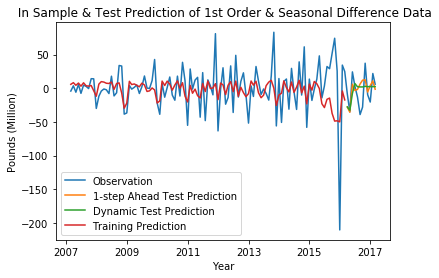

In [173]:
# Difference Data Prediction Visualization
fig=plt.figure()
date=pd.date_range(start='11/10/2006',end='03/01/2017',freq='MS')
date=date[-len_window:]

plt.plot(date,season_diff[-len_window:],label='Observation')
plt.plot(date[-test_size:],test_predict_sum_1stp,label='1-step Ahead Test Prediction')
plt.plot(date[-test_size:],test_predict_sum_dyn,label='Dynamic Test Prediction')
plt.plot(date[-len_window:-test_size],train_predict_sum,label='Training Prediction')
plt.ylabel('Pounds (Million)')
plt.xlabel('Year')
plt.legend()
plt.title(' In Sample & Test Prediction of 1st Order & Seasonal Difference Data')
plt.show()
fig.savefig('S1D1ForecaastFinal.png',dpi=1000)

##### Forecast Recovery and Visualization

In [174]:
# Reshift Back to First Order Difference
season_shift=sales_diff.shift(12)[-len_window:].values
# training
season_fis_forecast_rec=train_predict_sum+season_shift[-len_window:-test_size]
# 1 step ahead
season_test_1stp_forecast_rec=test_predict_sum_1stp+season_shift[-test_size:]
# dynamic
season_test_dyn_forecast_rec=test_predict_sum_dyn+season_shift[-test_size:]

# Reshift to Orignal Data
fst_shift=data.shift(1)[-len_window:].values
# training
fis_forecast_rec=season_fis_forecast_rec+fst_shift[-len_window:-test_size]
# 1 step ahead
test_1stp_forecast_rec=season_test_1stp_forecast_rec+fst_shift[-test_size:]
# dynamic
test_dyn_forecast_rec=season_test_dyn_forecast_rec+fst_shift[-test_size:]

In [189]:
pd.DataFrame(test_1stp_forecast_rec).to_excel('1stp.xlsx')
pd.DataFrame(test_dyn_forecast_rec).to_excel('dyn.xlsx')

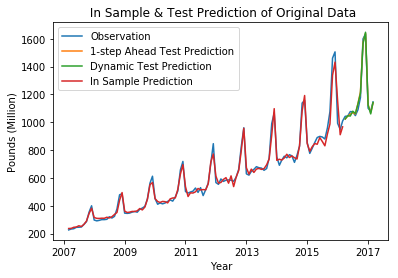

In [175]:
# Difference Data Prediction Visualization
fig=plt.figure()
date=pd.date_range(start='11/10/2006',end='03/01/2017',freq='MS')
date=date[-len_window:]

plt.plot(date,sales[-len_window:],label='Observation')
plt.plot(date[-test_size:],test_1stp_forecast_rec,label='1-step Ahead Test Prediction')
plt.plot(date[-test_size:],test_dyn_forecast_rec,label='Dynamic Test Prediction')
plt.plot(date[-len_window:-test_size],fis_forecast_rec,label='In Sample Prediction')
plt.ylabel('Pounds (Million)')
plt.xlabel('Year')
plt.legend()
plt.title(' In Sample & Test Prediction of Original Data')
plt.show()
fig.savefig('ForecaastFinal.png',dpi=1000)

#### Training and Cross Validation Loss

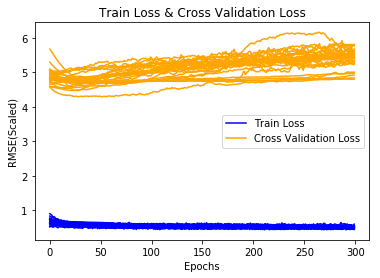

In [176]:
# Cross Validation Visualization
fig=plt.figure()
line1=plt.plot(np.array(train_loss)[0,:],color='blue',label="Train Loss")
plt.plot(np.array(train_loss)[1,:],color='blue')
plt.plot(np.array(train_loss)[2,:],color='blue')
plt.plot(np.array(train_loss)[3,:],color='blue')
plt.plot(np.array(train_loss)[4,:],color='blue')
plt.plot(np.array(train_loss)[5,:],color='blue')
plt.plot(np.array(train_loss)[6,:],color='blue')
plt.plot(np.array(train_loss)[7,:],color='blue')
plt.plot(np.array(train_loss)[8,:],color='blue')
plt.plot(np.array(train_loss)[9,:],color='blue')
plt.plot(np.array(train_loss)[10,:],color='blue')
plt.plot(np.array(train_loss)[11,:],color='blue')
plt.plot(np.array(train_loss)[12,:],color='blue')
plt.plot(np.array(train_loss)[13,:],color='blue')
plt.plot(np.array(train_loss)[14,:],color='blue')
plt.plot(np.array(train_loss)[15,:],color='blue')
plt.plot(np.array(train_loss)[16,:],color='blue')
plt.plot(np.array(train_loss)[17,:],color='blue')
plt.plot(np.array(train_loss)[18,:],color='blue')
plt.plot(np.array(train_loss)[19,:],color='blue')
plt.plot(np.array(train_loss)[20,:],color='blue')
plt.plot(np.array(train_loss)[21,:],color='blue')
plt.plot(np.array(train_loss)[22,:],color='blue')
plt.plot(np.array(train_loss)[23,:],color='blue')
plt.plot(np.array(train_loss)[24,:],color='blue')
plt.plot(np.array(train_loss)[25,:],color='blue')
plt.plot(np.array(train_loss)[26,:],color='blue')
plt.plot(np.array(train_loss)[27,:],color='blue')
plt.plot(np.array(train_loss)[28,:],color='blue')
plt.plot(np.array(train_loss)[29,:],color='blue')



line2=plt.plot(np.array(cv_loss)[0,:],color='orange',label= "Cross Validation Loss")
plt.plot(np.array(cv_loss)[1,:],color='orange')
plt.plot(np.array(cv_loss)[2,:],color='orange')
plt.plot(np.array(cv_loss)[3,:],color='orange')
plt.plot(np.array(cv_loss)[4,:],color='orange')
plt.plot(np.array(cv_loss)[5,:],color='orange')
plt.plot(np.array(cv_loss)[6,:],color='orange')
plt.plot(np.array(cv_loss)[7,:],color='orange')
plt.plot(np.array(cv_loss)[8,:],color='orange')
plt.plot(np.array(cv_loss)[9,:],color='orange')
plt.plot(np.array(cv_loss)[10,:],color='orange')
plt.plot(np.array(cv_loss)[11,:],color='orange')
plt.plot(np.array(cv_loss)[12,:],color='orange')
plt.plot(np.array(cv_loss)[13,:],color='orange')
plt.plot(np.array(cv_loss)[14,:],color='orange')
plt.plot(np.array(cv_loss)[15,:],color='orange')
plt.plot(np.array(cv_loss)[16,:],color='orange')
plt.plot(np.array(cv_loss)[17,:],color='orange')
plt.plot(np.array(cv_loss)[18,:],color='orange')
plt.plot(np.array(cv_loss)[19,:],color='orange')
plt.plot(np.array(cv_loss)[20,:],color='orange')
plt.plot(np.array(cv_loss)[21,:],color='orange')
plt.plot(np.array(cv_loss)[22,:],color='orange')
plt.plot(np.array(cv_loss)[23,:],color='orange')
plt.plot(np.array(cv_loss)[24,:],color='orange')
plt.plot(np.array(cv_loss)[25,:],color='orange')
plt.plot(np.array(cv_loss)[26,:],color='orange')
plt.plot(np.array(cv_loss)[27,:],color='orange')
plt.plot(np.array(cv_loss)[28,:],color='orange')
plt.plot(np.array(cv_loss)[29,:],color='orange')


plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE(Scaled)')
plt.title('Train Loss & Cross Validation Loss')
plt.show()
fig.savefig('loss_output.png',dpi=1000)

### Result Interpret Visualization Plot

#### Box Plot of Model Tuning Process

In [178]:
t3_data=pd.read_csv('test_loss.csv')
t3_data.head(10)

,N1,N2,N3,N4,N5
0,73.578849,72.351499,74.498024,82.176711,85.701434
1,71.041034,73.539004,73.779110,83.397234,76.726428
2,72.591598,71.803879,74.044446,76.516884,95.393377
3,72.831768,75.361877,73.358326,78.431738,81.470941
4,72.012841,74.500162,76.423331,82.055410,83.312501
5,71.307000,73.536701,78.577280,78.280035,87.553942
6,71.437664,73.817047,74.344667,81.467094,84.033081
7,70.606481,72.170360,74.762092,89.983912,85.511858
8,71.663357,77.840085,70.797480,88.916574,79.774779
9,70.509277,72.201103,72.613115,76.722812,85.588556


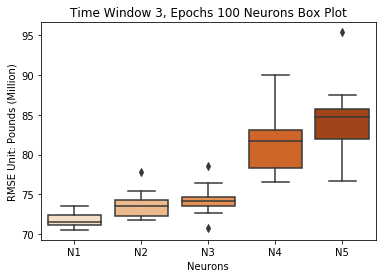

In [179]:
ax=sns.boxplot(data=t3_data, palette='Oranges')
ax.set_title('Time Window 3, Epochs 100 Neurons Box Plot')
ax.set_ylabel('RMSE Unit: Pounds (Million)')
ax.set_xlabel('Neurons')
ax.figure.savefig('T3NeuronsBoxPlot.png',dpi=1000)